# FCS/FCG released by WFP (vam food security analysis)

Link to *Food Consumption Score* data released by WFP: https://vam.wfp.org/mvam_monitoring/databank_fcs.aspx

Link to *Shapefile* data released by OCHA (The Humanitarian Data Exchange): https://data.humdata.org/

In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
plt.style.use("ggplot")

In [2]:
# Food Consumption Score (FCS/FCG) and relative FCGs values.
df = pd.read_excel("mVam_FoodConsumptionScore.xlsx")
df.head()

,Country,Year,Month,AdminStrata,Mean,Median,Poor,Borderline,Acceptable
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Democratic Republic of the Congo,2019.0,September,Kasai,22.64,21.0,75.58,15.12,9.30
2,Democratic Republic of the Congo,2019.0,September,Kasai-Central,18.25,16.5,86.74,11.11,2.15
3,Yemen,2019.0,September,Ad Dali,47.04,45.5,13.84,31.59,54.57
4,Yemen,2019.0,September,Al Hudaydah,56.92,53.0,7.54,23.43,69.03


ATTENTION: some items in the dataframe have NaN values in correspondence of temporal information and FCS/FCG values.

### Brief keys description

- *Country*: name of the country considered in the survey.
- *AdminStrata*: name of the provinces/regions of the country considered in the survey (or smaller granularity: districts, cities, camps, etc). 
- *Year, Month*: temporal information.
- *Mean, Median*: mean and median of the FCS household values.
- *Poor, Borderline, Acceptable*: Food Consumption Groups (FCGs).

### Preprocessing
#### Remove NaN values

In [3]:
# Show the sub-dataframe with NaN values.
nans = lambda df: df[df.isnull().any(axis = 1)]
print(nans(df).shape)
nans(df).head()

(435, 9)


,Country,Year,Month,AdminStrata,Mean,Median,Poor,Borderline,Acceptable
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
550,Yemen,2018.0,June,Al Bayda,NaN,NaN,NaN,NaN,NaN
551,Yemen,2018.0,June,Al Hudaydah,NaN,NaN,NaN,NaN,NaN
552,Yemen,2018.0,June,Sa'dah,NaN,NaN,NaN,NaN,NaN
553,Yemen,2018.0,June,Sana'a,NaN,NaN,NaN,NaN,NaN


In [4]:
# Take into consideration the dataframe unless NaN values.
df = pd.concat([df, nans(df)]).drop_duplicates(keep = False)
print("The consistent data available for a time-series analysis are:", len(df))
df.head()

The consistent data available for a time-series analysis are: 2207


,Country,Year,Month,AdminStrata,Mean,Median,Poor,Borderline,Acceptable
1,Democratic Republic of the Congo,2019.0,September,Kasai,22.64,21.00,75.58,15.12,9.30
2,Democratic Republic of the Congo,2019.0,September,Kasai-Central,18.25,16.50,86.74,11.11,2.15
3,Yemen,2019.0,September,Ad Dali,47.04,45.50,13.84,31.59,54.57
4,Yemen,2019.0,September,Al Hudaydah,56.92,53.00,7.54,23.43,69.03
5,Yemen,2019.0,September,Hadramaut,52.30,51.36,14.16,16.79,69.05


#### Other small fixes

Every country has an entry of the AdminStrata key equal to the self-name (Country key), I delete it. Moreover, the strings of AdminStrata key for Nigeria country are sometimes lowercase and sometimes uppercase, I change them to obtain uniform values (lowercase with first capital letter).

In [5]:
df = df[~df.AdminStrata.isin(df.Country.unique())]

In [6]:
def to_lower(country, admin):
    if country == "Nigeria":
        admin = admin.lower().title()      
    return admin
    
df["AdminStrata"] = df[["Country", "AdminStrata"]].apply(lambda x: to_lower(*x), axis = 1)

The Syria country has a "Not Included" item for the AdminStrata key, I delete it.

In [7]:
df = df[~df.AdminStrata.isin(["Not Included"])]

#### Creation of an accurate datetime feature

Creation of a datetime column merging the available time values (Year and Month keys) into one column (creating a deafult day (the end of the month) column to allow the use of pd.to_datetime command). I take a step back and I add the missing datetime values for every AdminStrata key of every country in order to show the real timeseries graphs (based on the own max and min datetime values).

In [8]:
data = pd.to_datetime(df["Year"].astype(int).astype(str) + df["Month"], format = "%Y%B") # Combine hour and date to datetime.
df.insert(1, "Datetime", data)
df.drop(["Year", "Month"], axis = 1, inplace = True) # Drop duplicate infomation.
df.sort_values("Datetime", ascending = True, inplace = True) # Sort on datetime.
df = df.groupby(["Country", "AdminStrata"]).apply(lambda group: group.set_index("Datetime").resample("M").mean()).reset_index()
df.reset_index(drop = True, inplace = True)
df.head()

,Country,AdminStrata,Datetime,Mean,Median,Poor,Borderline,Acceptable
0,Democratic Republic of the Congo,Buleusa,2016-12-31,33.20,31.0,33.33,53.33,13.33
1,Democratic Republic of the Congo,Buleusa,2017-01-31,NaN,NaN,NaN,NaN,NaN
2,Democratic Republic of the Congo,Buleusa,2017-02-28,NaN,NaN,NaN,NaN,NaN
3,Democratic Republic of the Congo,Buleusa,2017-03-31,21.55,21.0,92.11,7.90,0.00
4,Democratic Republic of the Congo,Eringeti,2016-11-30,29.64,30.0,37.74,60.38,1.89


## Analysis of the dataset

### Country key

In [9]:
#print(df.Country.describe())
print("The countries are:", ", ".join(df.Country.unique()))

The countries are: Democratic Republic of the Congo, Guinea, Iraq, Lesotho, Malawi, Nigeria, Swaziland, Syria, Yemen, Zambia


### AdminStrata key

- **Guinea**: Guinea is divided into eight administrative regions: Boke, Conakry, Faranah, Kankan, Kindia, Labe, Mamou, N'Zerekore. The FCS dataframe has the values of all the provinces. The shapefile for Guinea is available with regions granularity (Administrative Boundaries Level 1 for the OCHA dataset) with all 8 provinces.

- **Yemen**: The administrative division of Yemen is divided into two main divisions (governorates and districts). There are 22 governorates, including the capital Sana'a (Amanat Al Asima) and Socotra Archipelago. The FCS dataframe has the values of 21 of these provinces (Socotra Archipelago is not included). The shapefile for Zambia is available with governorates granularity (Administrative Boundaries Level 1 for the OCHA dataset) with all 22 provinces.

- **Swaziland** (and also known as Eswatini): Eswatini is divided into four regions: Hhohho, Lubombo, Manzini, and Shiselweni. The FCS dataframe has the values of all 4 regions. The shapefile for Swaziland country is not available.

- **Zambia**: Zambia is divided into 10 provinces for administrative purposes (Central, Copperbelt, Eastern, Luapula, Lusaka, Muchinga, North Western, Northern, Southern, Western). The FCS dataframe has the values of 5 of these provinces (Copperbelt, Eastern, Lusaka, Southern, Western). The shapefile for Zambia is available with provincial granularity (Administrative Boundaries Level 1 for the OCHA dataset) with all 10 provinces.

- **Democratic Republic of the Congo** (and also known as DR Congo): DR Congo has 26 major provinces (Kinshasa, Ituri Province, Kongo Central, Haut-Uele, Kwango, Tshopo, Kwilu Province, Bas-Uele, Mai-Ndombe Province, Nord-Ubangi, Kasaï Province, Mongala, Kasaï-Central, Sud-Ubangi, Kasaï-Oriental, Équateur, Lomami Province, Tshuapa, Sankuru, Tanganyika Province, Maniema, Haut-Lomami, South Kivu, Lualaba Province, North Kivu, Haut-Katanga Province). The AdminStrata items of the FCS dataframe not follow this structure:

    - Buleusa: Buleusa is a populated place in the Walikale Territory, the Democratic Republic of the Congo.
    - Eringeti: it is a town.
    - Kalinga: it is a populated place.
    - Kalunga: it is a populated place.
    - Kasai: Kasai Province is one of the 26 provinces of the Democratic Republic of the Congo.
    - Kasai-Central: Kasai Central is one of the 26 provinces of the Democratic Republic of the Congo.
    - Kibirizi: it is a village in North Kivu.
    - Kibua: it is a village in North Kivu.
    - Kilimani: it is a camp.
    - Lushebere: It is place in the North Kivu.
    - Mbau: Mbau is the capital of the Beni-Mbau sector in North Kivu in the east of the Democratic Republic of Congo.
    - Mugunga 3: Mugunga 3 is a camp.

- **Iraq**: Iraq is composed of nineteen governorates (or provinces). The governorates are subdivided into districts, which are further divided into sub-districts. 64 unique items are present under the voice AdminStrata key of the FCS dataframe and they are a mix of cities, camps, districts, sub-districts and provinces. 

- **Lesotho**: the AdminStrata items of the FCS dataframe represents the districts of Lesotho. In some case, some AdminStrata items are kept in couple.

- **Malawi**: the AdminStrata items of the FCS dataframe represents the districts of Malawi. In some case, some AdminStrata items are kept in couple or more.

- **Nigeria**: the AdminStrata items of the FCS dataframe cover 3 states (of the total 36 states) and each of these state is divede into three parts: North, South, Central.

- **Syria**:  the AdminStrata key of the FCS dataframe contains a mix of cities, camps, districts, sub-districts and provinces. 


N.B. For the some countries (Guinea, Yemen, Zambia; for the other countries the inhomogeneities of the granularity doesn't help to display them) is possible to represents FCGs values using the shapefiles. However for all countries (expect for Swaziland county) are availabe a set of shapefiles (administrative boundaries at different level of granularity).

### Computation of the metric

Compute the metric that it will be exploited for the forecasting analysis. The metric is simply the sum between the FCGs "Borderline" and "Acceptable".

In [10]:
def compute_metric(bord, acc):
    metric = bord + acc
    return metric

df["Metric"] = df[["Borderline", "Acceptable"]].apply(lambda x: compute_metric(*x), axis = 1)
df.head()

,Country,AdminStrata,Datetime,Mean,Median,Poor,Borderline,Acceptable,Metric
0,Democratic Republic of the Congo,Buleusa,2016-12-31,33.20,31.0,33.33,53.33,13.33,66.66
1,Democratic Republic of the Congo,Buleusa,2017-01-31,NaN,NaN,NaN,NaN,NaN,NaN
2,Democratic Republic of the Congo,Buleusa,2017-02-28,NaN,NaN,NaN,NaN,NaN,NaN
3,Democratic Republic of the Congo,Buleusa,2017-03-31,21.55,21.0,92.11,7.90,0.00,7.90
4,Democratic Republic of the Congo,Eringeti,2016-11-30,29.64,30.0,37.74,60.38,1.89,62.27


### Graphs of the metric for every countries and governatores (AdminStrata key)

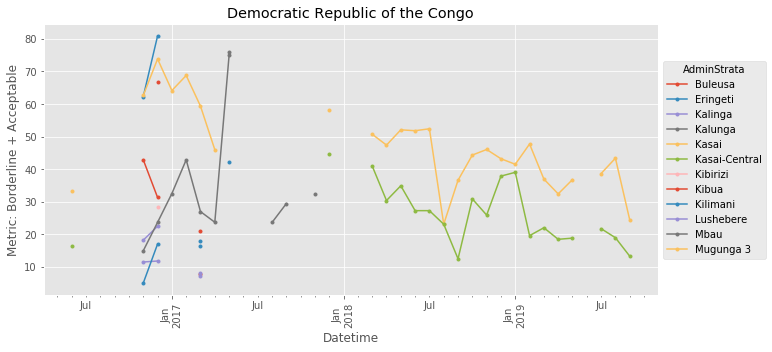

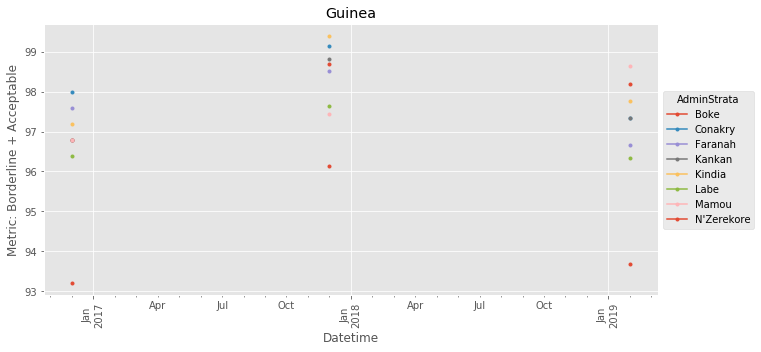

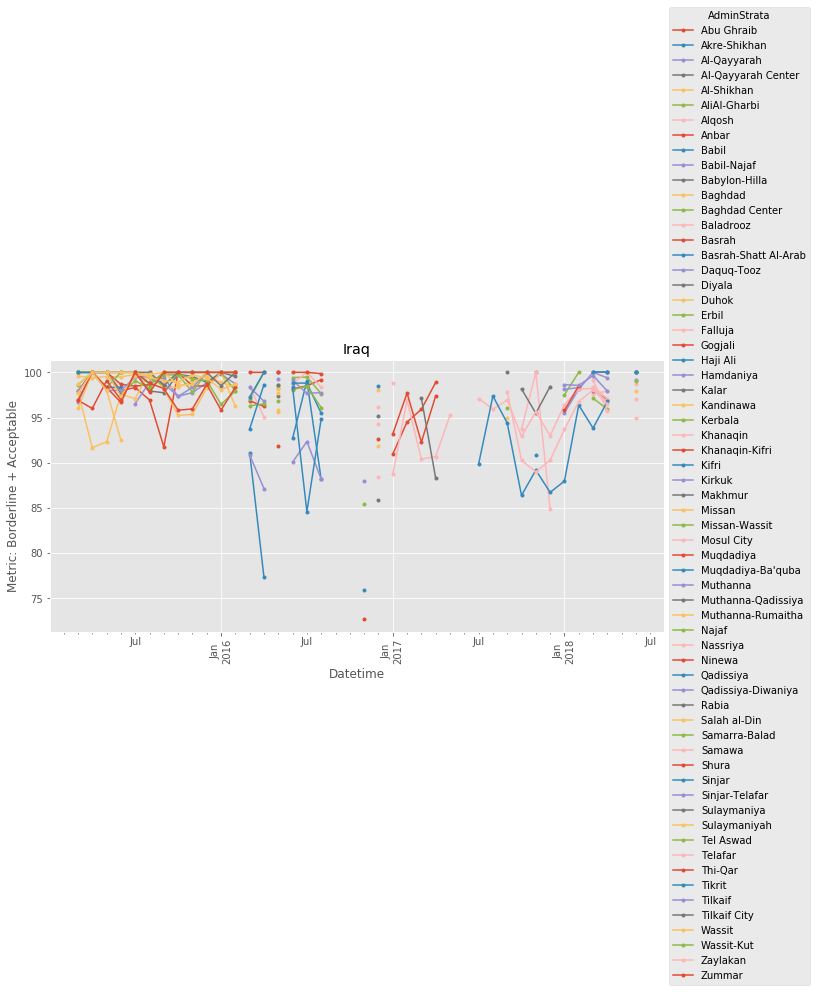

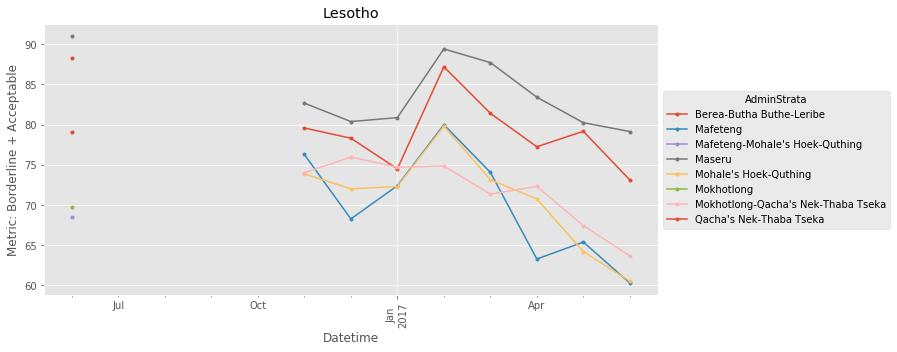

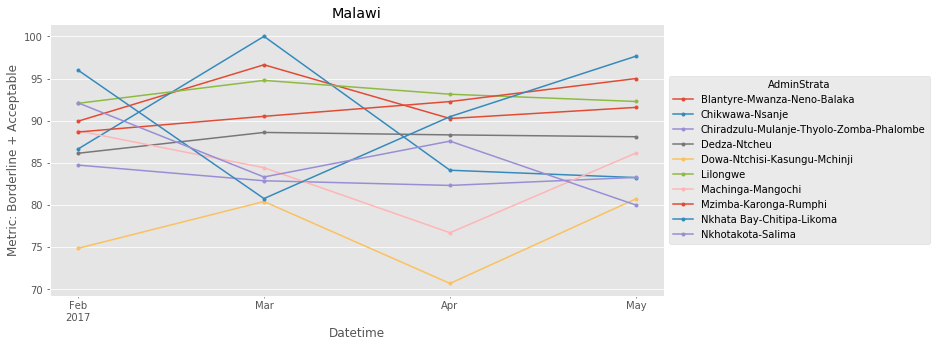

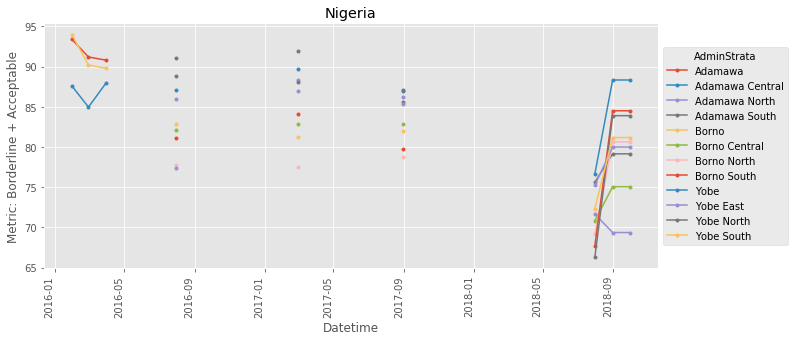

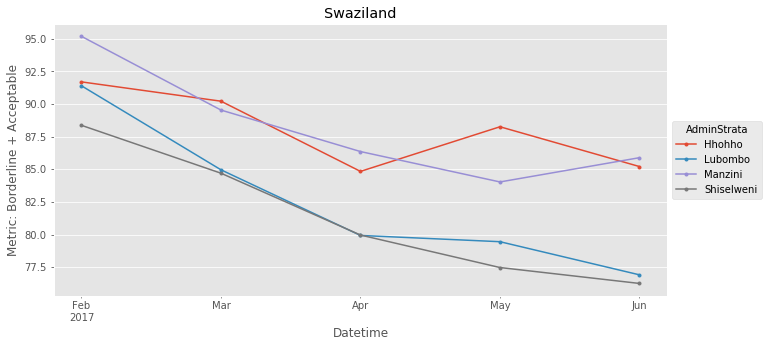

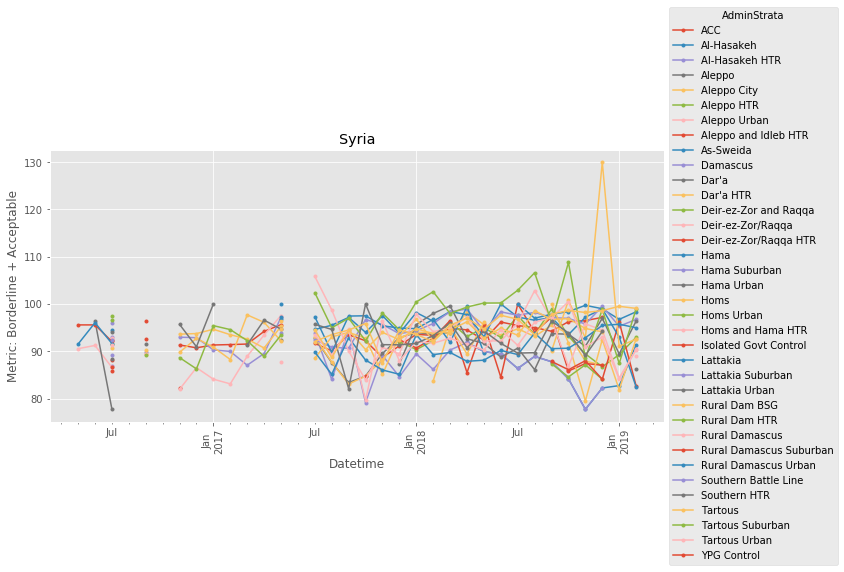

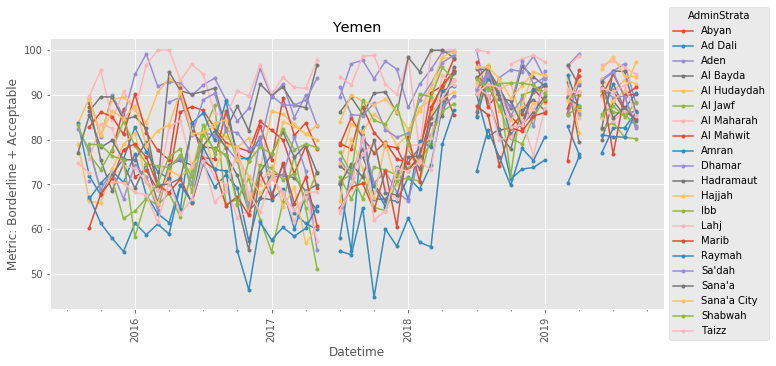

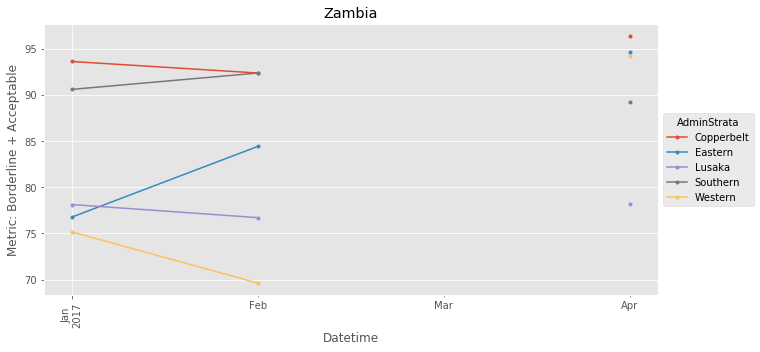

In [11]:
for country in df.Country.unique():
    sub_df = df[df.Country == country]
    f = plt.figure(figsize = (11, 5))
    plt.title(country, color = "black")
    sub_df.groupby(["Datetime", "AdminStrata"]).mean()["Metric"].unstack().plot(ax = f.gca(), style = ".-")
    plt.legend(title = "AdminStrata", loc = "center left", bbox_to_anchor = (1.0, 0.5))
    plt.ylabel("Metric: Borderline + Acceptable")
    plt.xticks(rotation = 90)
    plt.autoscale()
    plt.show()

### Shapefile representation

In [12]:
dict_shapefiles = {"Zambia": "zmb_popa_adm1_census2010f_ISCGM_CSO_OCHA_.shp",
                   "Yemen": "yem_admbnda_adm1_govyem_cso_20191002.shp",
                   "Guinea": "gin_admbnda_adm1_ocha_itos.shp"}

In [13]:
# Some AdminStrata keys don't fit between the FCS dataframe and the dataframe of shapefiles.
replacing_words = {"Yemen": [{"Ma'rib": "Marib", "Ta'iz": "Taizz", "Al Hodeidah": "Al Hudaydah", "Hadramawt": "Hadramaut", "Ad Dali'": "Ad Dali"}, {"ADM1_EN": "AdminStrata"}],
                   "Guinea": [{"Nzerekore": "N'Zerekore"}, {"admin1Name": "AdminStrata"}],
                   "Zambia": [None, {"PROVINCE": "AdminStrata"}]}

#### Example:

In [14]:
Country = "Yemen" # Yemen, Zambia or Guinea.
Month = 8
Year = 2019

In [15]:
shp_path = "./shape_files/" + Country + "_shapefile/" + dict_shapefiles[Country]
country = gpd.read_file(shp_path) 

In [16]:
country.rename(columns = replacing_words[Country][1], inplace = True)
if replacing_words[Country][0] != None:
    country.replace(replacing_words[Country][0], inplace = True)

In [17]:
df_plot = df[(df.Datetime.dt.month  == Month) & (df.Datetime.dt.year  == Year) & (df.Country == Country)]
df_plot.head()

,Country,AdminStrata,Datetime,Mean,Median,Poor,Borderline,Acceptable,Metric
1788,Yemen,Abyan,2019-08-31,48.88,46.88,13.66,31.36,54.98,86.34
1837,Yemen,Ad Dali,2019-08-31,46.39,46.00,17.39,25.77,56.85,82.62
1886,Yemen,Aden,2019-08-31,59.79,58.00,3.06,22.31,74.63,96.94
1935,Yemen,Al Bayda,2019-08-31,47.38,50.00,14.51,25.16,60.33,85.49
1985,Yemen,Al Hudaydah,2019-08-31,56.55,54.00,6.64,14.02,79.34,93.36


In [18]:
# Aggiungo la colonna relativa metrica al geopandas in questione.
country = pd.merge(country, df_plot[["AdminStrata", "Metric"]], on = ["AdminStrata"], how = "left") 

Text(0.5, 1, 'Yemen metric: Borderline + Acceptable')

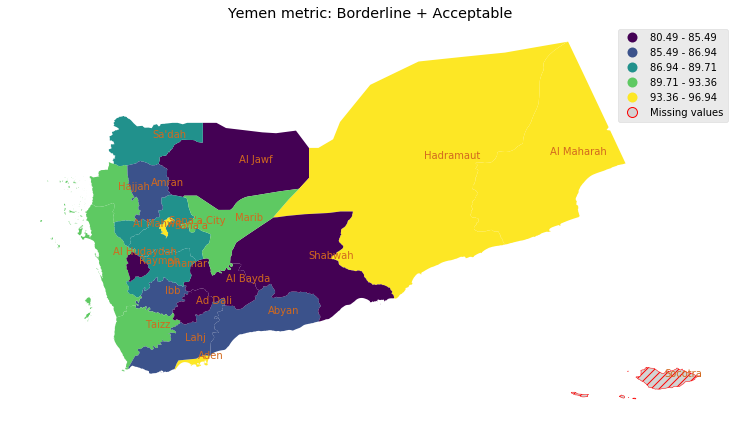

In [19]:
f, ax = plt.subplots(1, figsize = (13, 10))
ax = country.plot(column = "Metric", ax = ax, legend = True, scheme = "quantiles", missing_kwds = {"color": "lightgrey", "edgecolor": "red", "hatch": "///","label": "Missing values"})
for x, y, label in zip(country.centroid.x, country.centroid.y, country.AdminStrata):
    ax.annotate(label, xy = (x, y), xytext = (3, 3), textcoords = "offset points", color = "chocolate")
plt.axis("off")
plt.title(Country + " metric: Borderline + Acceptable")